In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import fnmatch
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

def imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height*0.3):int(height*0.8),:,:]  # remove top and botom of the image, as it is not relavant for lane following
    image = cv2.resize(image, (200,75)) # input image size (200,75) in model
    image = image / 255 # normalizing
    return image

data_dir = 'Bilder'
file_list = os.listdir(data_dir)
image_paths = []
images = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        path = os.path.join(data_dir,filename)
        image_paths.append(path)
        image = img_preprocess(imread(path))
        images.append(image)
        angle = int(filename[-7:-4])  # AAA part of timestamp_AAA.jpg --> AAA is the angle in range 045 - 135
        steering_angles.append(angle)     

In [2]:
#Numpy Arrays für die Lenroutine
images_np = np.array(images, dtype=np.float16)
angles_np = np.array(steering_angles)

steering_Angle: 117


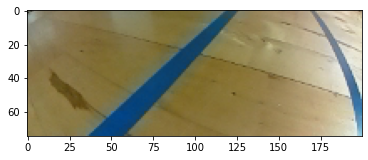

In [3]:
#Dataframe für Auswertung
df = pd.DataFrame()
df['Angle'] = steering_angles  

#Beispielbild
image_index = 30

plt.imshow(images[image_index])
print("steering_Angle: %d" % steering_angles[image_index] )

(75, 200, 3)


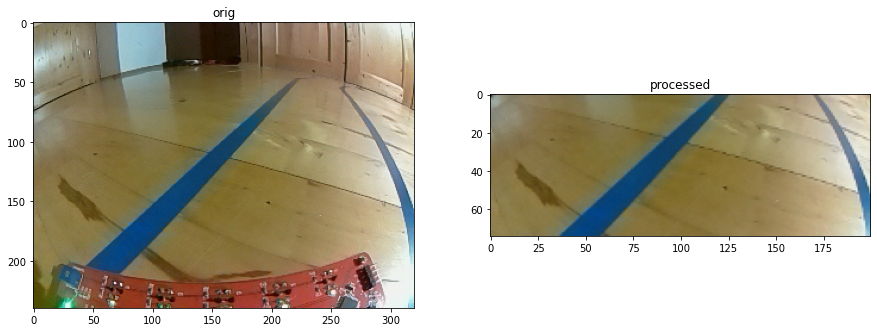

In [4]:
#Vergleich Originalbild mit bearbeitetem Bild
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = imread(image_paths[image_index])
image_processed = images[image_index]
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")
print(image_processed.shape)

(array([  5.,   7.,  23.,  45.,  60., 143., 165., 109.,  70.,  75.,  49.,
         58.,  65., 171., 143.,  49.,  36.,  68.,  94., 178., 160., 161.,
         50.,  15.,   1.]),
 array([ 55.  ,  57.76,  60.52,  63.28,  66.04,  68.8 ,  71.56,  74.32,
         77.08,  79.84,  82.6 ,  85.36,  88.12,  90.88,  93.64,  96.4 ,
         99.16, 101.92, 104.68, 107.44, 110.2 , 112.96, 115.72, 118.48,
        121.24, 124.  ]),
 <BarContainer object of 25 artists>)

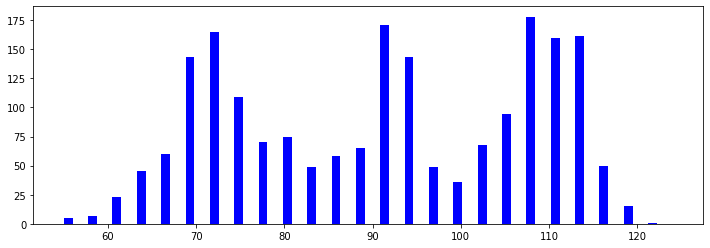

In [5]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

In [6]:
#Daten teilen
X_train, X_valid, y_train, y_valid = train_test_split( images_np, angles_np, test_size=0.2)
print(f"Training data: {len(X_train)} Validation data: {len(X_valid)}")

Training data: 1600 Validation data: 400


Text(0.5, 1.0, 'Validation Data')

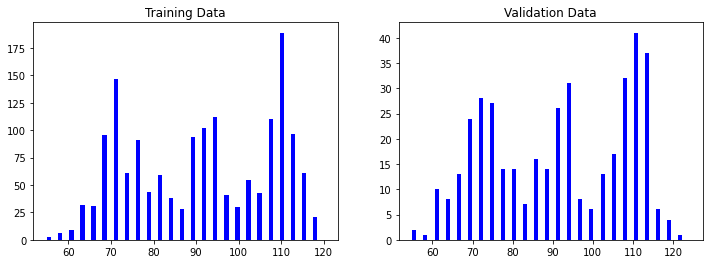

In [7]:
# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='blue')
axes[1].set_title('Validation Data')

In [8]:
def cnn_model():
    
    # Keras Sequntial API
    model = tf.keras.Sequential(name='Lenkwinkelerkennung') 
    
    # Convolution Layers
    # elu: Expenential Linear Unit, similar to leaky Relu
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(75, 200, 3), activation='elu')) 
    #model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(100, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten()) 
    model.add(Dropout(0.2)) # more robustness
    model.add(Dense(100, activation='elu')) 
    model.add(Dense(50, activation='elu')) 
    model.add(Dense(10, activation='elu'))

    # Output Layer: turning angle
    model.add(Dense(1)) 
    
    model.compile(loss='mse', optimizer = Adam(learning_rate=0.001))#, metrics =['accuracy'])
    
    return model

In [9]:
model = cnn_model()
#print(model.summary())

In [10]:
print(f"""X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}
      ...:X_valid.shape: {X_valid.shape}, y_valid.shape: {y_valid.shape}""")

X_train.shape: (1600, 75, 200, 3), y_train.shape: (1600,)
X_valid.shape: (400, 75, 200, 3), y_valid.shape: (400,)


In [17]:
history = model.fit(
    X_train,
    y_train,
    batch_size=1600,
    epochs=100,
    verbose=1,
    validation_data=(X_valid,y_valid)
)

Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 23.5123 - val_loss: 16.0737
Epoch 2/100
1/1 [==============================] - 10s 10s/step - loss: 23.0369 - val_loss: 16.1016
Epoch 3/100
1/1 [==============================] - 9s 9s/step - loss: 22.8648 - val_loss: 15.9685
Epoch 4/100
1/1 [==============================] - 9s 9s/step - loss: 22.8173 - val_loss: 16.0058
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 21.3432 - val_loss: 15.8942
Epoch 6/100
1/1 [==============================] - 9s 9s/step - loss: 21.9173 - val_loss: 15.7467
Epoch 7/100
1/1 [==============================] - 9s 9s/step - loss: 22.2638 - val_loss: 15.7994
Epoch 8/100
1/1 [==============================] - 9s 9s/step - loss: 21.4485 - val_loss: 15.6166
Epoch 9/100
1/1 [==============================] - 10s 10s/step - loss: 21.5468 - val_loss: 15.7716
Epoch 10/100
1/1 [==============================] - 9s 9s/step - loss: 21.7309 - val_loss: 15.4860
Epoch 11/100


Epoch 83/100
1/1 [==============================] - 10s 10s/step - loss: 14.8008 - val_loss: 10.9498
Epoch 84/100
1/1 [==============================] - 10s 10s/step - loss: 14.5092 - val_loss: 11.3715
Epoch 85/100
1/1 [==============================] - 10s 10s/step - loss: 14.4452 - val_loss: 10.8424
Epoch 86/100
1/1 [==============================] - 9s 9s/step - loss: 14.6851 - val_loss: 10.7305
Epoch 87/100
1/1 [==============================] - 10s 10s/step - loss: 14.5810 - val_loss: 10.8551
Epoch 88/100
1/1 [==============================] - 11s 11s/step - loss: 14.5317 - val_loss: 10.6888
Epoch 89/100
1/1 [==============================] - 9s 9s/step - loss: 14.6469 - val_loss: 11.4264
Epoch 90/100
1/1 [==============================] - 10s 10s/step - loss: 15.1959 - val_loss: 10.7039
Epoch 91/100
1/1 [==============================] - 9s 9s/step - loss: 14.6285 - val_loss: 10.9952
Epoch 92/100
1/1 [==============================] - 10s 10s/step - loss: 14.4459 - val_loss: 10.4

In [ ]:
history.history

In [12]:
def plot_training_curve(history, xlim=None, ylim=None,keys=['loss']):
    for key in keys:
        plt.figure(figsize=(5, 5))
        #plt.subplot(2, 2, 1)
        plt.plot(history.history[key], label=key)
        plt.plot(history.history['val_'+key], label='Validation '+key)
        plt.legend()
        plt.title('Training - '+key+' Function')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

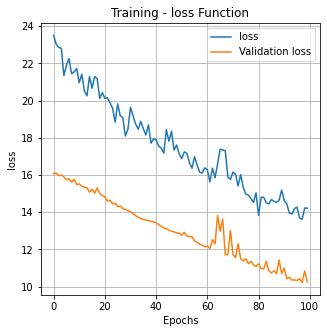

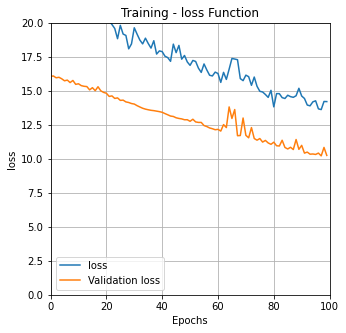

In [18]:
plot_training_curve(history)
# Vergößerung (xlim und ylim ev. anpassen!)
plot_training_curve(history,xlim=(0,100),ylim=(0,20))

In [19]:
model.save("angle2_400.h5")

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2f}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

y_pred = predict_and_summarize(X_valid, y_valid)

mse       = 10.26
r_squared = 96.48%



# Ab Hier können Testdaten eingelesen werden. Nicht mehr relevant für das Model

In [ ]:
data_dir = fr'Bilder\test'
file_list = os.listdir(data_dir)
image_paths_test = []
images_test = []
steering_angles_test = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        path = os.path.join(data_dir,filename)
        image_paths_test.append(path)
        image = img_preprocess(imread(path))
        images_test.append(image)
        angle = int(filename[-7:-4])  # AAA part of timestamp_AAA.jpg --> AAA is the angle in range 045 - 135
        steering_angles_test.append(angle)    
        
#Numpy Arrays für die Lenroutine
images_test_np = np.array(images_test, dtype=np.float16)
angles_test_np = np.array(steering_angles_test)

In [ ]:
X_test, y_test = images_test_np, angles_test_np

y_pred = predict_and_summarize(X_test, y_test)


In [ ]:
n_tests_show = 100
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(images_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

In [ ]:
for i in range(100):
    print(f"{i:03d} diff = {int(y_pred[i])-y_test[i]}")
